# Import Package

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
import moviepy as mve
%matplotlib inline

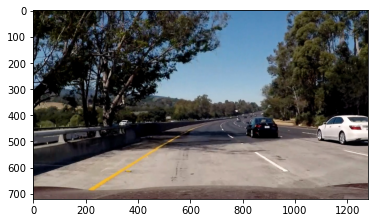

In [41]:
# Read the image check
image = mpimg.imread('test_images/test5.jpg')
plt.imshow(image)

# Sobel parameter

In [5]:
# parameter
thresh_min = 50
thresh_max = 255
sobel_kernel = 3
mag_thresh = (50, 255)
dir_thresh = (0.7, 1.3)
hls_thresh = (50,255)

# Image function 

In [43]:
def color_threshold_setting(image,red_threshold=0, green_threshold=0, blue_threshold=0):
    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    color_select = np.copy(image)
    # Define color selection criteria
    ###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
    # rgb 三個顏色小於某個閥值 濾掉不看
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Do a boolean or with the "|" character to identify
    # pixels below the thresholds
    # 其中一個符合 就濾掉給他等於[0,0,0] 使用 或 | 
    thresholds = (image[:,:,0] < rgb_threshold[0]) |\
                 (image[:,:,1] < rgb_threshold[1]) |\
                 (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    return color_select

def focus_view_triangle(image):
    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    triangle_image = np.copy(image)
    # Define the vertices of a triangular mask.
    # Keep in mind the origin (x=0, y=0) is in the upper left
    # MODIFY THESE VALUES TO ISOLATE THE REGION 
    # WHERE THE LANE LINES ARE IN THE IMAGE
    left_bottom = [0+50, ysize]
    right_bottom = [1280-50, ysize]
    apex = [xsize//2, ysize//2+30]
    # Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
    # np.polyfit returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))
    # Color pixels red where both color and region selections met
    triangle_image[~region_thresholds] = [0, 0, 255]
#     x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
#     y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
#     triangle_image=plt.plot(x, y, 'b--', lw=4)
    return triangle_image

def gray_image(image):
    gray = np.copy(image)
    gray = cv2.cvtColor(gray,cv2.COLOR_RGB2GRAY)
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = kernel_size # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    # Define our parameters for Canny and run it
    low_threshold = low_threshold
    high_threshold = high_threshold
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    return edges

def gray_drawhoughLines(image,kernel_size=3,low_threshold = 50,high_threshold = 150,
                        rho=2,theta=np.pi/180,threshold =15,min_line_length=10,max_line_gap=20):
    gray = np.copy(image)
    gray = cv2.cvtColor(gray,cv2.COLOR_RGB2GRAY)
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = kernel_size # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    # Define our parameters for Canny and run it
    low_threshold = low_threshold
    high_threshold = high_threshold
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255 
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
#     left_bottom = [0, ysize]
#     right_bottom = [1280, ysize]
#     apex = [xsize//2, ysize//2]
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2+10, imshape[0]//2+50),
                          (imshape[1]//2+10, imshape[0]//2+50), (imshape[1],imshape[0])]],
                        dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = rho # distance resolution in pixels of the Hough grid
    theta = theta # angular resolution in radians of the Hough grid
    threshold = threshold  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = min_line_length #minimum number of pixels making up a line
    max_line_gap = max_line_gap   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    return lines_edges
# image = mpimg.imread("camera_cal/calibration1.jpg")
# plt.imshow(image)
# some image can't find the right corner
# don't count it
# checkerboard = mpimg.imread('camera_cal/calibration1.jpg')
# # convert to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# # find the chessboard corners
# pattern_size=(9,6)
# f, corners = cv2.findChessboardCorners(gray, pattern_size, None)
# f
# from skimage import io
# fname = 'camera_cal/calibration2.jpg'
# img = io.imread(fname)
# fname = 'camera_cal/calibration2.jpg'
# img = cv2.imread(fname)
# prepare object points
nx = 9 # count by yourself
ny = 6 # count by yourself
pattern_size=(9,6)
fnames = glob.glob("camera_cal/calibration*.jpg")
pattern = np.zeros((pattern_size[1] * pattern_size[0], 3), np.float32)
pattern[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
pattern_points = [] # points in real world image
image_points = []   # points in image plane
image_size = None
calibrated_images=[]
failed_images=[]
for fname in fnames:
    checkerboard = mpimg.imread(fname)
    gray = cv2.cvtColor(checkerboard, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        pattern_points.append(pattern)
        image_points.append(corners)
        image_size = (checkerboard.shape[1], checkerboard.shape[0])
        cv2.drawChessboardCorners(checkerboard, (nx, ny), corners, ret)
        calibrated_images.append(checkerboard)
    else:
        failed_images.append(checkerboard)
if pattern_points and image_points:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pattern_points, image_points, image_size,None,None)
    
    
def undistort(image, pattern_points=pattern_points, image_points=image_points):
    """ undistort image """
    undistort_image=cv2.undistort(image, mtx, dist, None, mtx)
    return undistort_image
# TODO 
# 找出可以看到頂角的圖片留下 處理 
# 找不到的去掉 
# 留下的建了 還原失真矩陣
# calibrated_camera_images = (glob.glob('camera_cal/calibration*.jpg'))
# fnames = glob.glob("camera_cal/calibration*.jpg")
# for fname in fnames:
#     image = mpimg.imread(fname)
#     print(image.shape)
# 視野角度 處理
def perspective_transform(image):
    # 圖片的 寬 高
    height = image.shape[0]
    width = image.shape[1]
    # Quadrangle verties coordinates in the source image
    # 取要關注的點
    s1 = [width // 2 - 76, height * 0.625]
    s2 = [width // 2 + 76, height * 0.625]
    s3 = [-100, height]
    s4 = [width + 100, height]
    src = np.float32([s1, s2, s3, s4])
    # Quadrangle verties coordinates in the destination image
    # 轉成自己要的圖片
    d1 = [100, 0]
    d2 = [width - 100, 0]
    d3 = [100, height]
    d4 = [width - 100, height]
    dst = np.float32([d1, d2, d3, d4])
    # Given src and dst points we calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image
    warped = cv2.warpPerspective(image, M, (width, height))
    # We also calculate the oposite transform
    unwrap_m = cv2.getPerspectiveTransform(dst, src)
    # Return the resulting image and matrix 
    return (warped, unwrap_m)

# Calibrated Check

Corners detected:


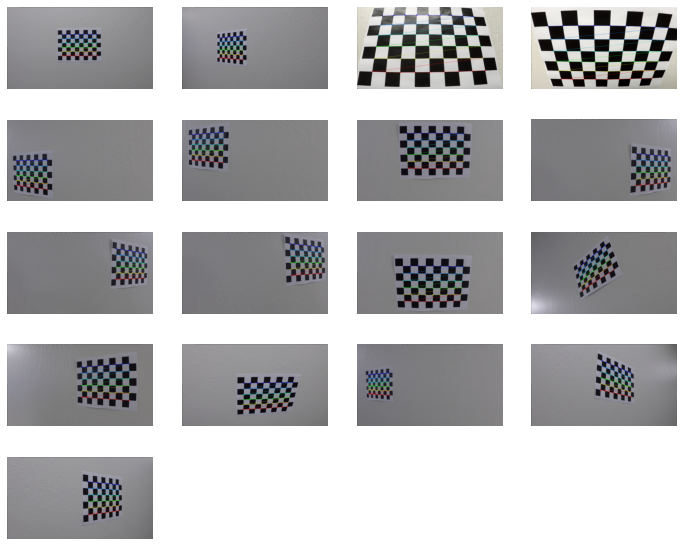

Unable to detect corners:


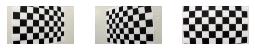

In [44]:
plt.figure(figsize=(12, 10))
gridspec.GridSpec(5, 4)
print('Corners detected:')
# Loop through the images and look for the chessboard corners
for i, calibrated_images, in enumerate(calibrated_images):
    plt.subplot2grid((5, 4), (i//4, i%4), colspan=1, rowspan=1)
    plt.imshow(calibrated_images)
    plt.axis('off')
plt.show()
print('Unable to detect corners:')
for i, failed_images, in enumerate(failed_images):
    plt.subplot2grid((5, 4), (i//4, i%4), colspan=1, rowspan=1)
    plt.imshow(failed_images)
    plt.axis('off')
plt.show()

# Sobel combined function 

In [8]:
def hls_select(image, thresh=hls_thresh):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    hls_output = np.zeros_like(s_channel)
    hls_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return hls_output


def Sobel_Operator(image,axis='x',thresh_min=thresh_min,thresh_max = thresh_max):
    image_c = np.copy(image)
#   gray = cv2.cvtColor(image_c, cv2.COLOR_RGB2GRAY)
#   hls = cv2.cvtColor(np.copy(image_c), cv2.COLOR_RGB2HLS).astype(np.float)
#   s = hls[:, :, 2]
    if axis == 'x':      
        abs_sobel = np.absolute(cv2.Sobel(image_c, cv2.CV_64F, 1, 0))
    elif axis == 'y':      
        abs_sobel = np.absolute(cv2.Sobel(image_c, cv2.CV_64F, 0, 1))
    thresh_min = thresh_min
    thresh_max = thresh_max
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    output = np.zeros_like(scaled_sobel)
    output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return output      
# output=Sobel_Operator(image,axis='x')
# plt.imshow(output, cmap='gray')
# show_bf_af_image(image,binary_output)
def mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=mag_thresh):
    # Convert to grayscale
    image_c = np.copy(image)
#   gray = cv2.cvtColor(image_c, cv2.COLOR_RGB2GRAY)
#     hls = cv2.cvtColor(np.copy(image_c), cv2.COLOR_RGB2HLS).astype(np.float)
#     s = hls[:, :, 2]
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image_c, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image_c, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    output_mag = np.zeros_like(gradmag)
    output_mag[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return output_mag
# output_mag=mag_thresh(image)
# plt.imshow(output_mag)
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(image, sobel_kernel=3, thresh=dir_thresh):
    # Grayscale
    image_c = np.copy(image)
#   gray = cv2.cvtColor(image_c, cv2.COLOR_RGB2GRAY)
#     hls = cv2.cvtColor(np.copy(image_c), cv2.COLOR_RGB2HLS).astype(np.float)
#     s = hls[:, :, 2]
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image_c, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image_c, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output_dir =  np.zeros_like(absgraddir)
    binary_output_dir[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output_dir
# binary_output_dir=dir_threshold(image)
# plt.imshow(binary_output_dir)
def Sobel_combined(image):
#     image_c = np.copy(image)
    image_c=hls_select(image)
    gradx = Sobel_Operator(image_c)
    grady = Sobel_Operator(image_c)
    mag_binary = mag_thresh(image_c)
    dir_binary = dir_threshold(image_c)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

# Finding the Lines: Sliding Window

In [9]:
# Load our image
def find_lane_pixels(image):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((image, image, image))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(image.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )



    return left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty


# def fit_polynomial(image):
#     # Find our lane pixels first
#     leftx, lefty, rightx, righty, out_img = find_lane_pixels(image)

#     # Fit a second order polynomial to each using `np.polyfit`
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)

#     # Generate x and y values for plotting
#     ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
#     try:
#         left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#         right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     except TypeError:
#         # Avoids an error if `left` and `right_fit` are still none or incorrect
#         print('The function failed to fit a line!')
#         left_fitx = 1*ploty**2 + 1*ploty
#         right_fitx = 1*ploty**2 + 1*ploty

#     ## Visualization ##
#     # Colors in the left and right lane regions
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     return  out_img, left_fit, right_fit, ploty, lefty, leftx, righty, rightx

def curvatures(lefty, leftx, righty, rightx, ploty):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/730 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
#     if lefty & leftx
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

# Finding the Lines: Search from Prior

In [10]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
# left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
# right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

# def fit_poly(img_shape, leftx, lefty, rightx, righty):
#      ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
#     ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
#     return left_fitx, right_fitx, ploty

# def search_around_poly(binary_warped):
#     # HYPERPARAMETER
#     # Choose the width of the margin around the previous polynomial to search
#     # The quiz grader expects 100 here, but feel free to tune on your own!
#     margin = 100

#     # Grab activated pixels
#     nonzero = binary_warped.nonzero()
#     nonzeroy = np.array(nonzero[0])
#     nonzerox = np.array(nonzero[1])
    
#     ### TO-DO: Set the area of search based on activated x-values ###
#     ### within the +/- margin of our polynomial function ###
#     ### Hint: consider the window areas for the similarly named variables ###
#     ### in the previous quiz, but change the windows to our new search area ###
#     left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
#                     left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
#                     left_fit[1]*nonzeroy + left_fit[2] + margin)))
#     right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
#                     right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
#                     right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
#     # Again, extract left and right line pixel positions
#     leftx = nonzerox[left_lane_inds]
#     lefty = nonzeroy[left_lane_inds] 
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds]

#     # Fit new polynomials
#     left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
#     ## Visualization ##
#     # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     ## End visualization steps ##
    
#     return result

# Myself function 

In [11]:
def show_bf_af_image(before,after):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(48, 18))
    f.tight_layout()
    ax1.imshow(before)
    ax1.set_title('Before Image', fontsize=20)
    ax2.imshow(after)
    ax2.set_title('After Image', fontsize=20)
    plt.subplots_adjust(left=0.2, right=0.4, top=0.9, bottom=0.5)
    
def is_same_image(image1,image2):
    difference = cv2.subtract(image1, image2)
    find = not np.any(difference) #if difference is all zeros it will return False
    if image.shape==edges.shape==0:
        result = "兩張圖片格式就已經不同了"
    elif find is True:
        result = "兩張圖片一樣"
    else:
        cv2.imwrite("result.jpg", difference)
        result = "兩張圖片不一樣"
    return result

# Color,View amd Hough

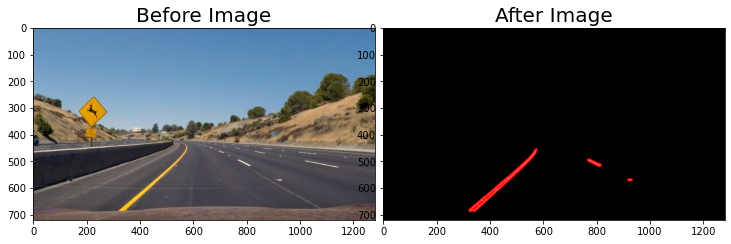

In [12]:
color_select = color_threshold_setting(image,250,0,0)
triangle_image = focus_view_triangle(color_select)
lines_edges = gray_drawhoughLines(triangle_image)
# Uncomment the following code if you are running the code locally and wish to save the image
# mpimg.imsave("test-after.png", color_select)
show_bf_af_image(image,lines_edges)

# Undistort

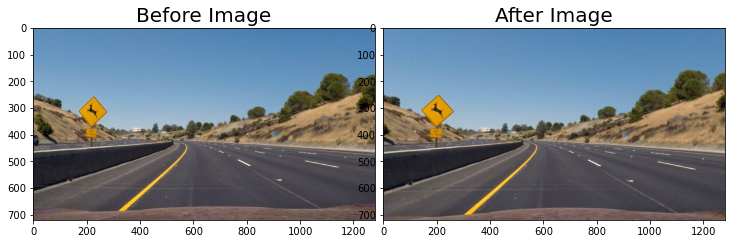

In [13]:
undistort_image=undistort(image)
show_bf_af_image(image,undistort_image)

# Perspective

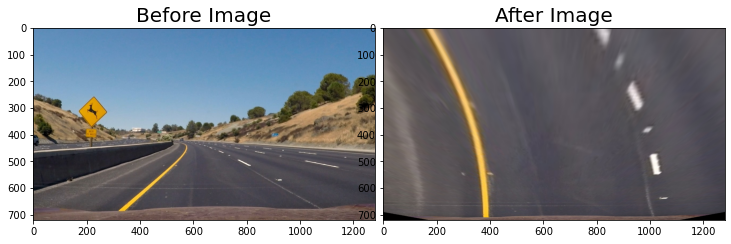

In [14]:
# 將每一個圖片轉換
# for image in glob.glob('test_images/test*.jpg'):
#     image = mpimg.imread(image)
#     transformed, _ = perspective_transform(image) 
    
#     _, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
#     x1.axis('off')
#     x1.imshow(image)
#     x1.set_title('Original', fontsize=20)

#     x2.axis('off')
#     x2.imshow(transformed)
#     x2.set_title('Transformed', fontsize=20)
transformed, utransformed = perspective_transform(image) 
show_bf_af_image(image,transformed)

# Sobel

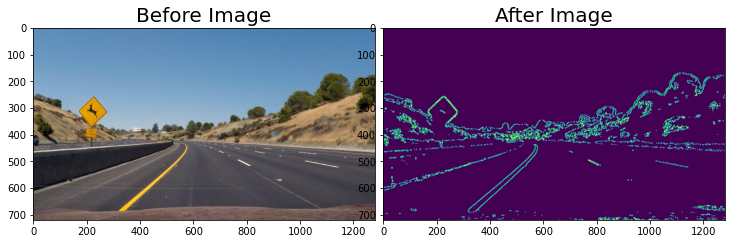

In [15]:
test=Sobel_combined(image)
show_bf_af_image(image,test)

# Combined

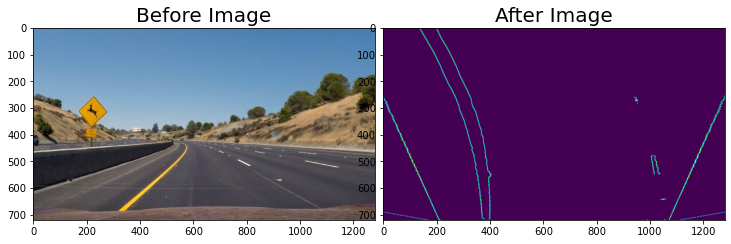

In [16]:
def combined(image):
    undistort_image=undistort(image)
#    color_select = color_threshold_setting(undistort_image,250,0,0)
    triangle_image = focus_view_triangle(undistort_image)
#     lines_edges = gray_drawhoughLines(triangle_image)
    transformed, utransformed = perspective_transform(triangle_image) 
    image=Sobel_combined(transformed)
    return image,utransformed
# Uncomment the following code if you are running the code locally and wish to save the image
# mpimg.imsave("test-after.png", color_select)
test,utransformed=combined(image)
show_bf_af_image(image,test)

# Detecting Lanes using Histogram

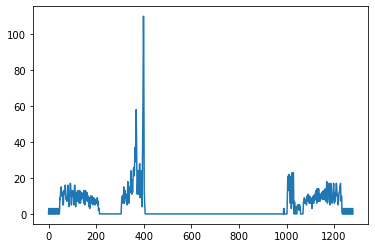

In [17]:
binary_warped,utransformed=combined(image)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# Slide Window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


383.87439049471203 m 505.36399021952695 m


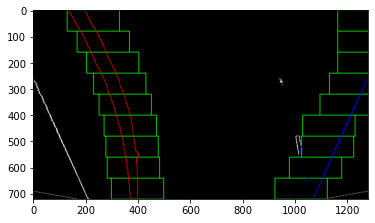

In [18]:
test,utransformed=combined(image)
# out_img,left_fit, right_fit,ploty,out_img, lefty, leftx, righty, rightx = fitlines(binary_warped)
left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty = find_lane_pixels(test)
#Testing Function
left_curverad, right_curverad = curvatures(lefty, leftx, righty, rightx, ploty)    
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
plt.imshow(out_img)

# Search from Prior

In [19]:
# result = search_around_poly(test)
# # View your output
# plt.imshow(result)

In [20]:
def draw_lane(img, warped, left_fit, right_fit, ploty, left_curverad, right_curverad, utransformed):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, utransformed, (image.shape[1], image.shape[0])) 
    
    # Creating Text and set font parameters
    TextL = "Left  Curvature: " + str(int(left_curverad)) + " m"
    TextR = "Right Curvature: " + str(int(right_curverad))+ " m"
    fontScale=1.5
    thickness=3
    fontFace = cv2.FONT_HERSHEY_SIMPLEX

    # Using CV2 putText to write text into images
    cv2.putText(newwarp, TextL, (110,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, TextR, (110,110), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result

# Testing the Function
# drawed_lane = draw_lane(img, binary_warped, left_fit, right_fit, ploty, left_curverad, right_curverad, utransformed)
# # Plot the Result
# plt.figure(figsize=(20,10))
# plt.imshow(drawed_lane)

In [21]:
def pipeline(image):
    # creating a Binary Undistorced Warped Image
    trans, utransformed = combined(image)
    # Fiting Lines
    left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty = find_lane_pixels(trans) 
    # Calulating the left and right lines curvatures
    left_curverad, right_curverad = curvatures(lefty, leftx, righty, rightx, ploty)
    # Draw Lane between road lines
    result_lane = draw_lane(image, trans, left_fit, right_fit, ploty, left_curverad, right_curverad, utransformed)                              
    return result_lane   

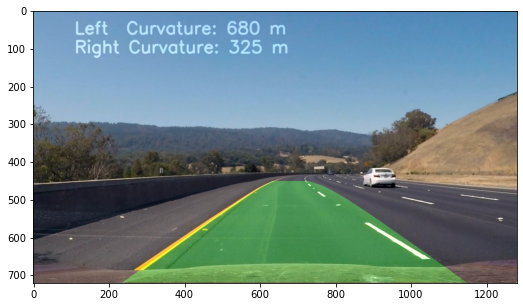

In [30]:
#read image
image = mpimg.imread('test_images/test3.jpg')
resultado = pipeline(image)
plt.figure(figsize=(10,5))
plt.imshow(resultado)

# Output_images

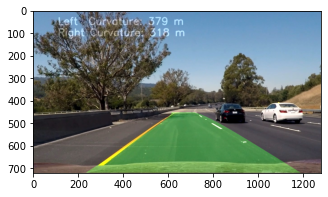

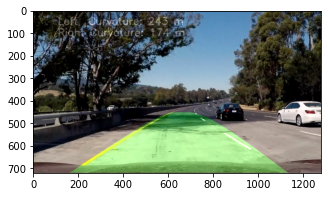

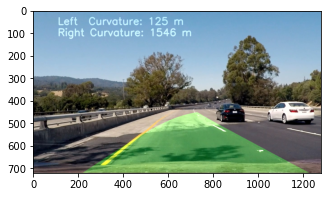

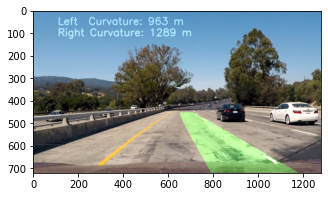

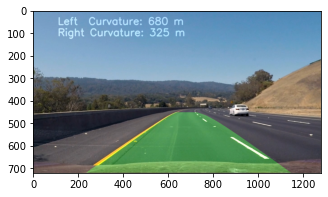

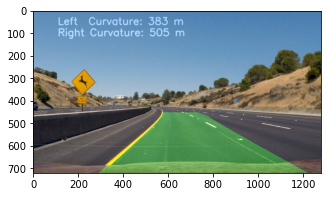

In [23]:
# test_images = glob.glob('test_images/test*.jpg')
for image_path in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(image_path)
    edit = pipeline(image)
   
    mpimg.imsave(image_path.replace('test_images', 'output_images'), edit)
    plt.figure(figsize=(5, 2.5))
    plt.imshow(edit)
    plt.subplots_adjust(left=0.0, right=5, top=0.9, bottom=0.0)
    plt.show() 

In [27]:
#Create video file pipeline
out_test_video = 'output_video/out_test_video.mp4'
clip1 = VideoFileClip("videos/project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(1,2)

out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(out_test_video, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_video/out_test_video.mp4.
Moviepy - Writing video output_video/out_test_video.mp4



Moviepy - Done !
Moviepy - video ready output_video/out_test_video.mp4
CPU times: user 8min 2s, sys: 1min 37s, total: 9min 39s
Wall time: 7min 46s


In [32]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(out_test_video))

In [33]:
#Create video file pipeline
out_test_challenge_video = 'output_video/out_test_challenge_video.mp4'
clip1 = VideoFileClip("videos/challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(1,2)

out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(out_test_challenge_video, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_video/out_test_challenge_video.mp4.
Moviepy - Writing video output_video/out_test_challenge_video.mp4



t: 100%|██████████| 485/485 [02:37<00:00,  3.21it/s, now=None]WARNING:py.warnings:/Users/logoming/opt/anaconda3/lib/python3.7/site-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file videos/challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)



Moviepy - Done !
Moviepy - video ready output_video/out_test_challenge_video.mp4
CPU times: user 3min 17s, sys: 34.5 s, total: 3min 52s
Wall time: 2min 39s


In [35]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(out_test_challenge_video))

In [36]:
#Create video file pipeline
out_test_harder_challenge_video = 'output_video/out_test_harder_challenge_video.mp4'
clip1 = VideoFileClip("videos/harder_challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(1,2)

out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(out_test_harder_challenge_video, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_video/out_test_harder_challenge_video.mp4.
Moviepy - Writing video output_video/out_test_harder_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_video/out_test_harder_challenge_video.mp4
CPU times: user 8min 20s, sys: 1min 26s, total: 9min 47s
Wall time: 6min 24s


In [37]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(out_test_harder_challenge_video))